In [2]:
import numpy as np
import pandas as pd
import requests, zipfile, io, os
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
import seaborn as sns


data doi:
    https://www.nature.com/articles/nmeth.2810#Sec15
further reading:
    https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

In [96]:
# download Dataset with Bash

#!bash download_datasets.sh

In [36]:
# download Dataset with python

data_directory = "cancer_datasets_test"

headers = {'Connection': 'keep-alive',
           'Host': 'static-content.springer.com',
           'Referer': 'https://www.nature.com/',
           'Upgrade-Insecure-Requests': '1',
           'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
           'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:88.0) Gecko/20100101 Firefox/88.0',
           'Accept-Language': 'en-US,en;q=0.5'}


url = 'https://static-content.springer.com/esm/art%3A10.1038%2Fnmeth.2810/MediaObjects/41592_2014_BFnmeth2810_MOESM206_ESM.zip'
request = requests.get(url, headers= headers, stream=True)
zip_reader = zipfile.ZipFile(io.BytesIO(request.content))
zip_reader.extractall(data_directory)


done
done


In [3]:
# create dataframes
data_directory = "cancer_datasets" 
cancer_types = ["Breast", "Colon", "GBM", "Lung"] 
file_ending = ["_Gene_Expression_cleaned.csv", "_Methy_Expression_cleaned.csv", 
                "_Mirna_Expression_cleaned.csv", "_Survival_cleaned.csv"] 
breast_dir_path = os.path.join(data_directory, cancer_types[0]) 
colon_dir_path = os.path.join(data_directory, cancer_types[1]) 
gbm_dir_path = os.path.join(data_directory, cancer_types[2]) 
lung_dir_path = os.path.join(data_directory, cancer_types[3]) 

breast_gene_exp_df = pd.read_csv(os.path.join(breast_dir_path, cancer_types[0].upper() + file_ending[0]),  
                                 sep="\t", index_col="Gene") 
colon_gene_exp_df = pd.read_csv(os.path.join(colon_dir_path, cancer_types[1].upper() + file_ending[0]), 
                                sep="\t", index_col="Gene") 
gbm_gene_exp_df = pd.read_csv(os.path.join(gbm_dir_path, "GLIO" + file_ending[0]), 
                              sep="\t", index_col="Gene") 
lung_gene_exp_df = pd.read_csv(os.path.join(lung_dir_path, cancer_types[3].upper() + file_ending[0]), 
                               sep="\t", index_col="Gene") 


In [4]:
# one hot encode target 

category_array = np.asarray([[cancer_type] for cancer_type in cancer_types]) 
ohe = OneHotEncoder(sparse=False)  
encoded_category = ohe.fit_transform(category_array) 
category_oh_encoded = dict(zip(cancer_types, 
                            encoded_category)) 

# label encode target
le = LabelEncoder()
le_encoded_category = le.fit_transform(cancer_types)
category_le_encoded = dict(zip(cancer_types, 
                           le_encoded_category)) 


In [5]:
# create list of common genes

breast_genes = list(breast_gene_exp_df.index)
colon_genes = list(colon_gene_exp_df.index)
gbm_genes = list(gbm_gene_exp_df.index)
lung_genes = list(lung_gene_exp_df.index)

all_genes = [breast_genes, colon_genes, gbm_genes, lung_genes]

overlap_genes = set.intersection(*map(set,all_genes))

In [6]:
# create input array and target array

input_array = np.array([])
input_array_first = ""
wanted_genes = list(overlap_genes)
  
for df, cancer_type in zip([breast_gene_exp_df, colon_gene_exp_df, 
                            gbm_gene_exp_df,lung_gene_exp_df],
                            cancer_types): 
   
   
    if input_array.size == 0:
        input_array = df.reindex(wanted_genes).transpose().values
        target_array = np.tile(category_le_encoded[cancer_type],
                                     (df.shape[1],1))
   
    else:
        current_input_array = df.reindex(wanted_genes).transpose().values
        input_array = np.vstack((input_array, current_input_array))
        current_target_array = np.tile(category_le_encoded[cancer_type],
                                     (df.shape[1],1))
        target_array = np.vstack((target_array, current_target_array))


    


In [7]:
# normalize with standard scaler

scaler = StandardScaler()
scaler.fit(input_array)
scaled_input = scaler.transform(input_array)
scaled_input.shape

(518, 11925)

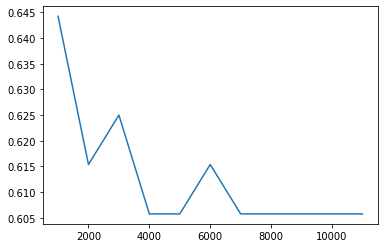

In [8]:
# feature selection with svc

model =  SVC(gamma='auto')
data_dict = {}

for K in range(1000, len(overlap_genes), 1000):
    selector = SelectKBest(score_func=f_classif, k=K)
    selected_input = selector.fit_transform(scaled_input, target_array.ravel())
    #best_genes_index = selector.get_support(indices=True)
    #best_genes =[list(overlap_genes)[i] for i in best_genes_index]
    X_train, X_test, y_train, y_test = train_test_split(selected_input,
                                                    target_array.ravel(),
                                                    test_size=0.2,
                                                    random_state=42)
    model.fit(X_train, y_train)
    mean_accuracy = model.score(X_test, y_test)
    data_dict[K] = mean_accuracy
    

sns.lineplot(list(data_dict.keys()), list(data_dict.values()))
    

In [252]:
# benchmark with dummy classifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)

0.25961538461538464